<a href="https://colab.research.google.com/github/halaaab/IT_326-Project-Group-1/blob/main/Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[1] Problem**

Breast cancer is one of the most common cancers affecting women worldwide. Early and accurate diagnosis is crucial for improving treatment outcomes and patient survival rates.
This project aims to analyze a dataset containing features computed from digitized images of fine-needle aspirates (FNA) of breast masses. By applying classification and clustering techniques, we aim to predict whether a tumor is malignant or benign, and to explore patterns and similarities among cases to gain deeper insights into the characteristics of cancerous and non-cancerous cells.

**[2] Data Mining Task**

In this project, we apply two essential data mining techniques: classification and clustering, to predict and better understand breast cancer diagnosis.
For classification, we train a Decision Tree model using features extracted from digitized images of fine-needle aspirates (FNA) of breast masses. These features — such as mean radius, texture, smoothness, compactness, and symmetry — describe the characteristics of cell nuclei.
The goal is to predict whether a tumor is malignant or benign, making this a binary classification problem. The Decision Tree approach is used to learn interpretable rules that can support medical diagnosis and decision-making.
For clustering, we apply the K-Means algorithm to group samples with similar feature patterns without using the diagnosis label. This unsupervised analysis helps uncover hidden structures in the data, identify potential subgroups of tumors, and provide insights into the underlying relationships among the measured features.
Together, these two techniques offer both predictive power and exploratory understanding, supporting early detection and deeper insight into breast cancer characteristics.

**[3] Data**

Markdown cell:
Dataset: Breast Cancer Wisconsin (Diagnostic) from UCI Machine Learning Repository.
• Total records: 569
• Attributes: 30 numeric features describing nuclei properties (radius, texture, area, smoothness, etc.)
• Target label: diagnosis → (M = malignant = 1, B = benign = 0)
• Non-predictive column: id removed during preprocessing.
The dataset was cleaned and normalized in Phase 2 to prepare it for analysis.

In [17]:
# ===== [1] Import Libraries =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# ===== [2] Load Dataset =====
data = pd.read_csv("Preprocessed_dataset.csv")

In [18]:
# ===== [3] Feature Selection =====
# We'll keep all columns except explicitly defining which one is our target
if data['diagnosis'].dtype == object:
    y = data['diagnosis'].str.strip().str.upper().map({'M':1, 'B':0}).astype(int)
else:
    y = data['diagnosis'].astype(int)

# Use all columns (you requested not to drop any)
X = data.copy()
feature_names = X.columns.tolist()

print("Class distribution in diagnosis column:")
print(y.value_counts())
print("\nFeature Names:", feature_names)


Class distribution in diagnosis column:
diagnosis
0    357
1    212
Name: count, dtype: int64

Feature Names: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'symmetry_se', 'symmetry_worst']


In [19]:
# ===== [4] Splitting Dataset =====
# Stratify ensures both classes (Malignant / Not Malignant) appear in each set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (398, 14)
Testing set size: (171, 14)


# Confusion Matrix

Confusion Matrix:
 [[107   0]
 [  0  64]]


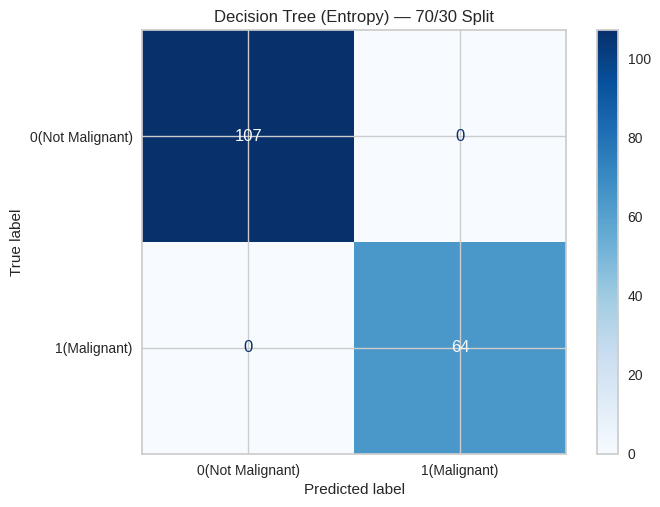

In [24]:
# 3) Train model using Entropy (Information Gain)
clf = DecisionTreeClassifier(criterion='entropy', random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 4) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0(Not Malignant)", "1(Malignant)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree (Entropy) — 70/30 Split")
plt.show()


# Confusion Matrix Interpretation



# Decesion Tree

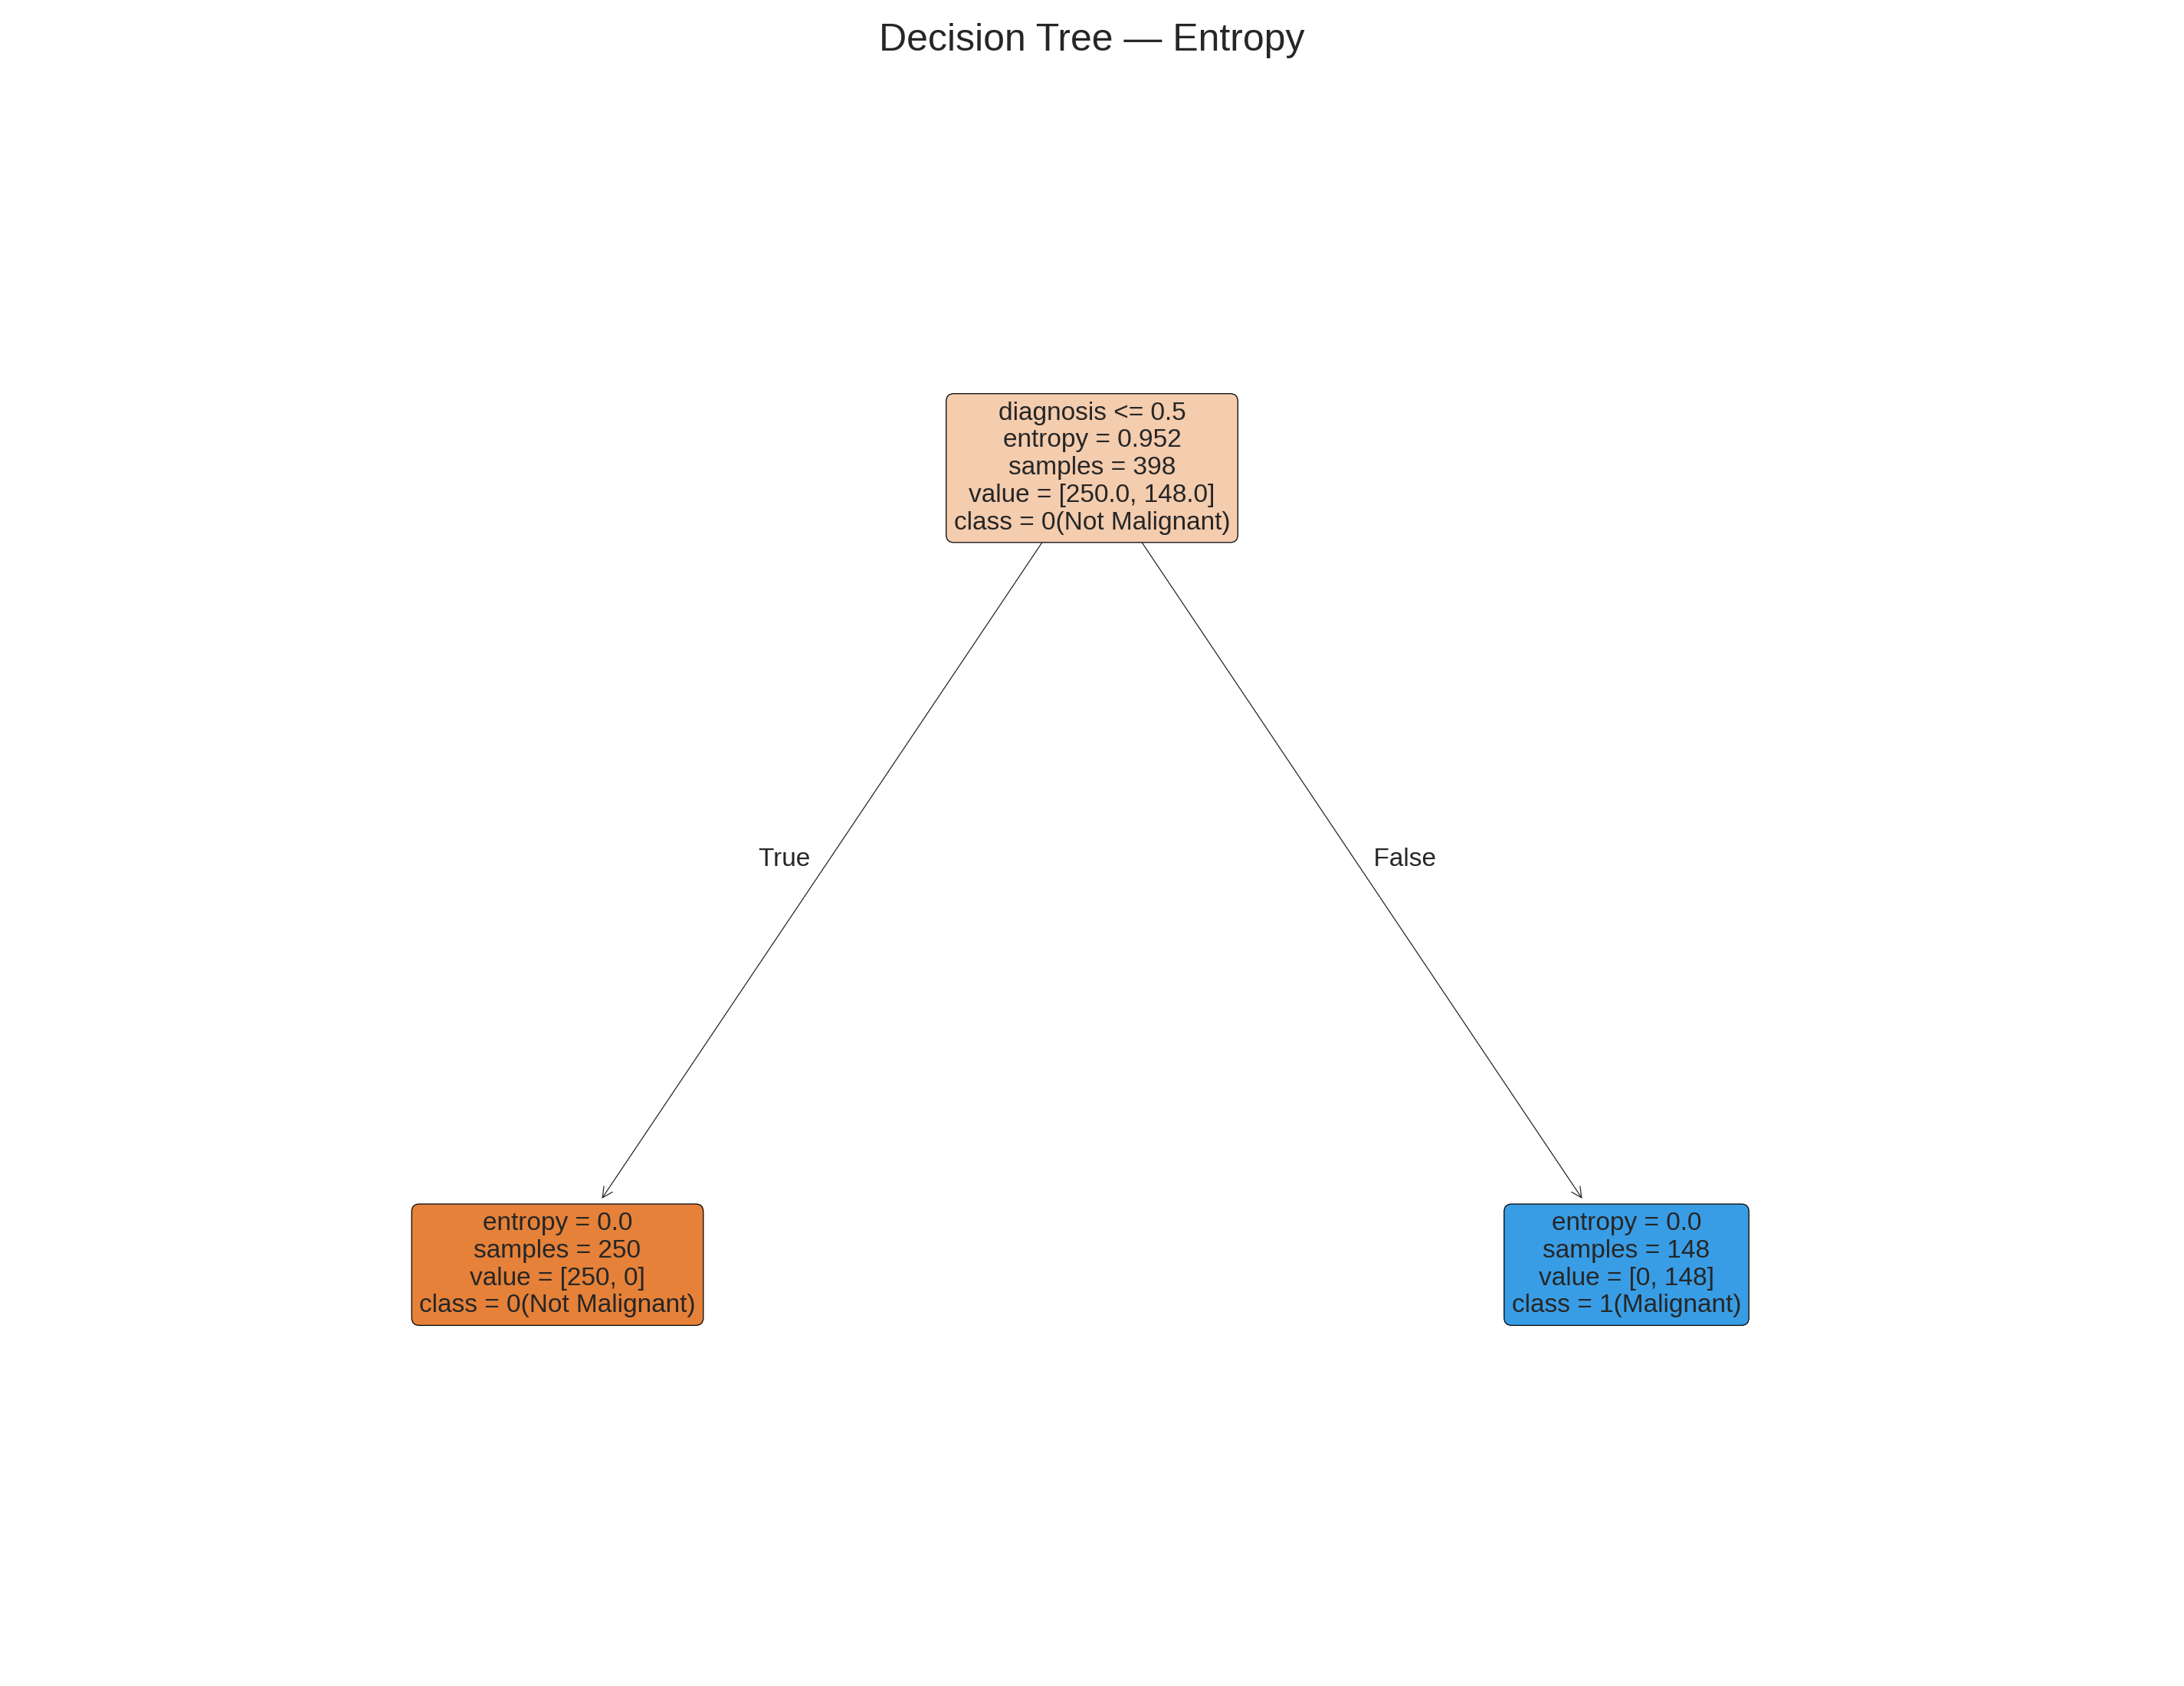

In [32]:
fn = X.columns.tolist()  # same columns used to fit the model

# 2) Class names that follow the model's learned class order
pretty = {0: "0(Not Malignant)", 1: "1(Malignant)"}
cls = [pretty.get(int(c), str(c)) for c in clf.classes_]  # aligns to clf.classes_

# 3) Plot
plt.figure(figsize=(12, 9), dpi=300)
tree.plot_tree(
    clf,
    feature_names=fn,
    class_names=cls,      # <- uses the exact order clf learned
    filled=True,
    rounded=True,
    impurity=True,
    fontsize=8
)
plt.title("Decision Tree — Entropy")
plt.show()

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix : \n", cm)

# Compute Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Error Rate
error_rate = 1 - accuracy
print("Error Rate:", error_rate)

# Extract TN, FP, FN, TP
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Sensitivity (Recall)
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Specificity
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# Precision
precision = TP / (TP + FP)
print("Precision:", precision)


confusion matrix : 
 [[107   0]
 [  0  64]]
Accuracy: 1.0
Error Rate: 0.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
